# Goal:

In this assignment, you will implement a [DDPM](https://arxiv.org/abs/2006.11239) class on MNIST dataset using PyTorch according to the guidence. The goal is to minimize the loss function and train the model to generate MNIST images.

The `Train` and `UNet` classes are already implemented for you. You need to implement the `DDPM` class (see details below) according to what is covered in the lecture ([slides](https://www.dropbox.com/s/0gu91rovro71q90/Diffusion.pdf?dl=0)). The images generated by the model will be automatically shown according to the `Trainer` class implementation. Make sure the generated images are shown in the output, it will be graded.

Grade:
- **DDPM class implementation (20 points).**
- **Trainer class completion (10 points)**
- **Training the model to generate reasonable Digits images within 20 epochs (10 points).**
- **Write a report to describe:**
     - **the sample images generated by each epochs (5 points)**
     - **the images generated at different steps t by the trained model (5 points)**

**Please note that the function to generate the images is already provided.**

---
Please DO NOT change the code provided, only add your own code where indicated. It is recommended that you **use CPU session to debug** when GPU is not necessary since Colab only gives 12 hrs of free GPU access at a time. If you use up the GPU resource, you may consider using Kaggle GPU resource. Thank you and good luck!

# Pre-determined config and given functions (no need to change)

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass 

Add the following files to your directory:
- args.py
- unet.py
- dataset.py
- utils.py

In [2]:
import torch
import torch.utils.data
from torch import nn
from typing import Tuple, Optional
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.amp import GradScaler, autocast

from ddpm_utils.args import *
from ddpm_utils.dataset import *
from ddpm_utils.unet import *
from q2_trainer_ddpm import *


In [3]:
print(f"Using {args.device} backend")

Using cuda backend


# Finish the DenoiseDiffusion model implementation

<img src="images/diffusion_model.png" width=800px height=500px />

We initialize ${\epsilon_\theta}(x_t, t)$, $\beta_1, \dots, \beta_T$ (linearly increasing variance schedule), $\alpha_t = 1 - \beta_t$, $\bar\alpha_t = \prod_{s=1}^t \alpha_s$, $\sigma^2 = \beta$
```python
class DenoiseDiffusion:
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model = eps_model
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps
        self.sigma2 = self.beta
```

## q_sample

We need to implement the function to get samples from $q(x_t|x_0)$.

\begin{align}
q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)
\end{align}

Hint: sampling from $\mathcal{N} \Big(\mu, \sigma^2\Big)$ is the same as sampling from $\mathcal{N} \Big(0, I\Big)$ then scale and shift.

To do so, we need to implment the function:
```python
    def q_xt_x0(
        self, x0: torch.Tensor, t: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        ...
        return mean, var
```

and

```python
    def q_sample(
        self, x0: torch.Tensor, t: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        ...
        return sample
```

## p_sample
We need to implement the function to get samples from ${p_\theta}(x_{t-1}|x_t)$

\begin{align}
{p_\theta}(x_{t-1} | x_t) &= \mathcal{N}\big(x_{t-1};
{\mu_\theta}(x_t, t), \sigma_t^2 \mathbf{I} \big) \\
{\mu_\theta}(x_t, t)
  &= \frac{1}{\sqrt{\alpha_t}} \Big(x_t -
    \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}{\epsilon_\theta}(x_t, t) \Big)
\end{align}

*   `beta` is defined as $1-\alpha_t$  
*   `eps_coef` is defined as $\frac{\beta}{\sqrt{1-\bar\alpha_t}}$
*   `mu_theta` is defined as $\frac{1}{\sqrt{\alpha_t}} \Big(x_t -\frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\epsilon_\theta(x_t, t) \Big)$
*   `var` is defined as $\sigma_t^2 \mathbf{I} = \beta_t \mathbf{I}$

To do so, we need to implement the functions:
```python
    def p_xt_prev_xt(
        self, xt: torch.Tensor, t: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        ...
        return mu_theta, var
```

and

```python
    def p_sample(
        self, xt: torch.Tensor, t: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        ...
        return sample
```

## loss
We need to implment the function to get the loss:
$$L(\theta) = \mathbb{E}_{t,x_0, \epsilon} \Bigg[ \bigg\Vert
\epsilon - {\epsilon_\theta}(\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon, t)
\bigg\Vert^2 \Bigg]$$

where `x_t` is sampled from $q(x_t|x_0)$ which is given by $\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon$


In [4]:
import torch 
from torch import nn 
from typing import Optional, Tuple


class DenoiseDiffusion():
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model = eps_model
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps
        self.sigma2 = self.beta


    ### UTILS
    def gather(self, c: torch.Tensor, t: torch.Tensor):
        c_ = c.gather(-1, t)
        return c_.reshape(-1, 1, 1, 1)

    ### FORWARD SAMPLING
    def q_xt_x0(self, x0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # TODO: return mean and variance of q(x_t|x_0)
        abt = self.gather(self.alpha_bar, t)
        mean = torch.sqrt(abt)*x0
        var = 1.0 - abt

        return mean, var

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None):
        if eps is None:
            eps = torch.randn_like(x0)
        # TODO: return x_t sampled from q(•|x_0) according to (1)
        abt = self.gather(self.alpha_bar, t)
        mean = torch.sqrt(abt)*x0
        std = torch.sqrt(1.0 - abt)
        sample = mean + std * eps

        return sample

    ### REVERSE SAMPLING
    def p_xt_prev_xt(self, xt: torch.Tensor, t: torch.Tensor):
        # TODO: return mean and variance of p_theta(x_{t-1} | x_t) according to (2)
        noise = self.eps_model(xt, t)
        at = self.gather(self.alpha, t)
        abt = self.gather(self.alpha_bar, t)
        bt = self.gather(self.beta, t)

        coefficient = bt/torch.sqrt(1.0 - abt)
        mu_theta = (1.0/torch.sqrt(at))*(xt - coefficient*noise)
        var = bt

        return mu_theta, var

    # TODO: sample x_{t-1} from p_theta(•|x_t) according to (3)
    def p_sample(self, xt: torch.Tensor, t: torch.Tensor, set_seed=False):
        if set_seed:
            torch.manual_seed(42)
        
        mu, var = self.p_xt_prev_xt(xt, t)
        noise = torch.randn_like(xt)
        std = torch.sqrt(var)
        t_is_zero = (t==0).reshape(-1,1,1,1)
        sample = mu + std*noise*(1.0 - t_is_zero.float())

        return sample

    ### LOSS
    # TODO: compute loss according to (4)
    def loss(self, x0: torch.Tensor, noise: Optional[torch.Tensor] = None, set_seed=False):
        if set_seed:
            torch.manual_seed(42)
        batch_size = x0.shape[0]
        dim = list(range(1, x0.ndim))
        t = torch.randint(
            0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long
        )
        if noise is None:
            noise = torch.randn_like(x0)
        # TODO
        xt = self.q_sample(x0, t, noise)
        pred_noise = self.eps_model(xt, t)
        loss = torch.mean(((noise - pred_noise)**2).sum(dim = dim))

        return loss


# Build trainer

In [5]:
import torch
from matplotlib import pyplot as plt 
from tqdm import tqdm
from torch.amp import GradScaler, autocast
import copy
import numpy as np

from ddpm_utils.args import *
import os

torch.manual_seed(42)

gdrive_dir = '../IFT6135-Assignment3/output'

def one_param(m):
    "get model first parameter"
    return next(iter(m.parameters()))

class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())


class Trainer:
    def __init__(self, args, eps_model, diffusion_model):

        self.eps_model = eps_model.to(args.device)

        self.diffusion = diffusion_model

        self.optimizer = torch.optim.Adam(
            self.eps_model.parameters(), lr=args.learning_rate
        )
        self.args = args
        self.current_epoch = 0

        self.ema = EMA(0.995)
        self.ema_model = copy.deepcopy(self.eps_model).eval().requires_grad_(False)



    def train_epoch(self, dataloader, scaler):
        current_lr = round(self.optimizer.param_groups[0]['lr'], 5)
        i = 0
        running_loss = 0.
        with tqdm(range(len(dataloader)), desc=f'Epoch : - lr: - Loss :') as progress:
            for x0 in dataloader:
                i += 1
                # Move data to device
                x0 = x0.to(self.args.device)
                # Calculate the loss
                with autocast(device_type=args.device, enabled=self.args.fp16_precision):
                    loss = self.diffusion.loss(x0)
                
                # Zero gradients
                self.optimizer.zero_grad()
                # Backward pass
                scaler.scale(loss).backward()
                scaler.step(self.optimizer)
                scaler.update()
                self.ema.step_ema(self.ema_model, self.eps_model)

                running_loss += loss.item()

                self.loss_per_iter.append(running_loss / i)
                progress.update()
                progress.set_description(f'Epoch: {self.current_epoch}/{self.args.epochs} - lr: {current_lr} - Loss: {round(running_loss / i, 2)}')
            progress.set_description(f'Epoch: {self.current_epoch}/{self.args.epochs} - lr: {current_lr} - Loss: {round(running_loss / len(dataloader), 2)}')

            # Step the scheduler after each epoch
            self.scheduler.step()


    def train(self, dataloader):
            scaler = GradScaler(device=self.args.device, enabled=self.args.fp16_precision)
            self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.1)
            start_epoch = self.current_epoch
            self.loss_per_iter = []
            for current_epoch in range(start_epoch, self.args.epochs):
                self.current_epoch = current_epoch
                self.train_epoch(dataloader, scaler)

                if current_epoch % self.args.show_every_n_epochs == 0:
                    self.sample()

                if (current_epoch + 1) % self.args.save_every_n_epochs == 0:
                    self.save_model()


    def sample(self, n_steps=None, set_seed=False):
        if set_seed:
            torch.manual_seed(42)
        if n_steps is None:
            n_steps = self.args.n_steps
            
        with torch.no_grad():
            # $x_T \sim p(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$
            x = torch.randn(
                [
                    self.args.n_samples,
                    self.args.image_channels,
                    self.args.image_size,
                    self.args.image_size,
                ],
                device=self.args.device,
            )
            if self.args.nb_save is not None:
                saving_steps = [self.args["n_steps"] - 1]
            # Remove noise for $T$ steps
            for t_ in tqdm(range(n_steps)):
                
                # TODO: Sample x_t 
                t = torch.full((self.args.n_samples,), n_steps - t_ - 1, device = self.args.device, dtype=torch.long)
                x = self.diffusion.p_sample(x, t)

                if self.args.nb_save is not None and t_ in saving_steps:
                    print(f"Showing/saving samples from epoch {self.current_epoch}")
                    self.show_save(
                        x,
                        show=True,
                        save=True,
                        file_name=f"DDPM_epoch_{self.current_epoch}_sample_{t_}.png",
                    )
        return x

    def save_model(self):
        torch.save({
                'epoch': self.current_epoch,
                'model_state_dict': self.eps_model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                }, args.MODEL_PATH)

    def show_save(self, img_tensor, show=True, save=True, gdrive_dir=gdrive_dir, file_name="sample.png"):
        fig, axs = plt.subplots(3, 3, figsize=(10, 10))  # Create a 4x4 grid of subplots
        assert img_tensor.shape[0] >= 9, "Number of images should be at least 9"
        img_tensor = img_tensor[:9]
        for i, ax in enumerate(axs.flat):
            # Remove the channel dimension and convert to numpy
            img = img_tensor[i].squeeze().cpu().numpy()

            ax.imshow(img, cmap="gray")  # Display the image in grayscale
            ax.axis("off")  # Hide the axis

        plt.tight_layout()
        if save:
            os.makedirs(f"{gdrive_dir}/ddpm/images", exist_ok=True)
            plt.savefig(os.path.join(gdrive_dir, "ddpm", "images", file_name))
        if show:
            plt.show()
        plt.close(fig)
        
        
    def generate_intermediate_samples(self, n_samples=4, img_size=32, steps_to_show=[0,999], n_steps=None, set_seed=False):
        """
        Generate multiple images and return intermediate steps of the diffusion process
        Args:
            n_samples: Number of images to generate
            img_size: Size of the images (assumes square images)
            every_n_steps: Capture intermediate result every n steps
        Returns:
            List of tensors representing the images at different steps
        """
        
        if set_seed:
            torch.manual_seed(42)
        
        if n_steps is None:
            n_steps = args.n_steps
            
        # Start from random noise
        x = torch.randn(n_samples, 1, img_size, img_size, device=args.device, requires_grad=False)

        # Store images at each step we want to show
        images = []
        images.append(x.detach().cpu().numpy())  # Initial noise

        for step in tqdm(range(1, n_steps+1, 1)):
            # TODO: Generate intermediate steps
            # Hint: if GPU crashes, it might be because you accumulate unused gradient ... don't forget to remove gradient
            t = torch.full((n_samples,), step, device = self.args.device, dtype=torch.long)
            with torch.no_grad():
                x = self.diffusion.q_sample(x, t)
        
            # Store intermediate result if it's a step we want to display
            if step in steps_to_show:
                images.append(x.detach().cpu().numpy())

        return images

# Build backbone model

The most common choice of NN architecture for image diffusion models is the U-Net, which gets its name from the U-shape of the architecture as shown in the diagram below.

Like an autoencoder, a U-Net consists of several downsampling stages in which the filter dimension of the image representation is first increased and then the spatial dimensions are downsampled, a bottleneck, and then several upsampling stages in which these downsampling transformations are reversed. The main difference between a U-Net and a standard autoencoder architecture is that at each stage in the upsampling path with include the original representation from the corresponding downsampling stage.

One motivation for using a U-Net rather than a standard autoencoder is that the final representation has information from various frequencies. Another is that the ResNet-like connections in the U-Net help with training due to improved gradient propagation.

<img src="images/téléchargement.jpeg" width=800px height=400px>

In [6]:
eps_model = UNet(c_in=1,c_out=1)
eps_model = load_weights(eps_model, args.MODEL_PATH)

No weights to load


# Start training when you finish filling the code above
Expected time: About `40s` for each epoch (`15 epoches` in total), if you don't change the config parameters. No model-checkpoint-saving logic is implemented. Please feel free to implement it if you need it. There will be samples displayed and saved (in `.png` images) during training for every epoch. You should be able to find the saved images in the `Files` on the left hand side if you are using Google colab.

Notice: `15 epoches` in total is just a safe setting to generate MNIST-style images. Usually, it should start to generate interpretable images around `6 epoches` with loss around `16`. If you don't see this, there may be something wrong with your implementation. Please double check your code before trying to having more epoches of training. Thanks!

In [7]:
diffusion_model = DenoiseDiffusion(
            eps_model=eps_model,
            n_steps=args.n_steps,
            device=args.device,
        )

trainer = Trainer(args, eps_model, diffusion_model)

dataloader = torch.utils.data.DataLoader(
    MNISTDataset(),
    batch_size=args.batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=0,
    pin_memory=True,
)

 99%|█████████▉| 993/1000 [00:04<00:00, 210.07it/s]

Showing/saving samples from epoch 0


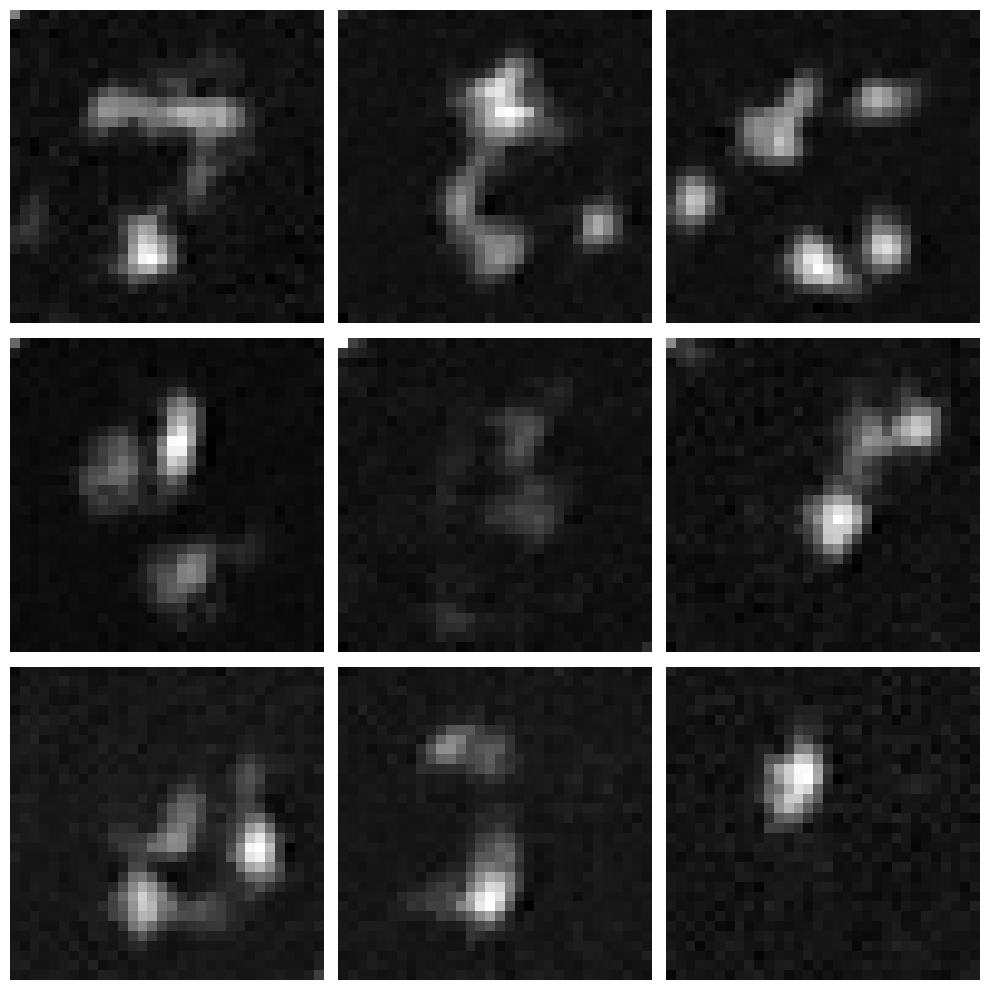

 99%|█████████▉| 990/1000 [00:04<00:00, 206.95it/s]

Showing/saving samples from epoch 2


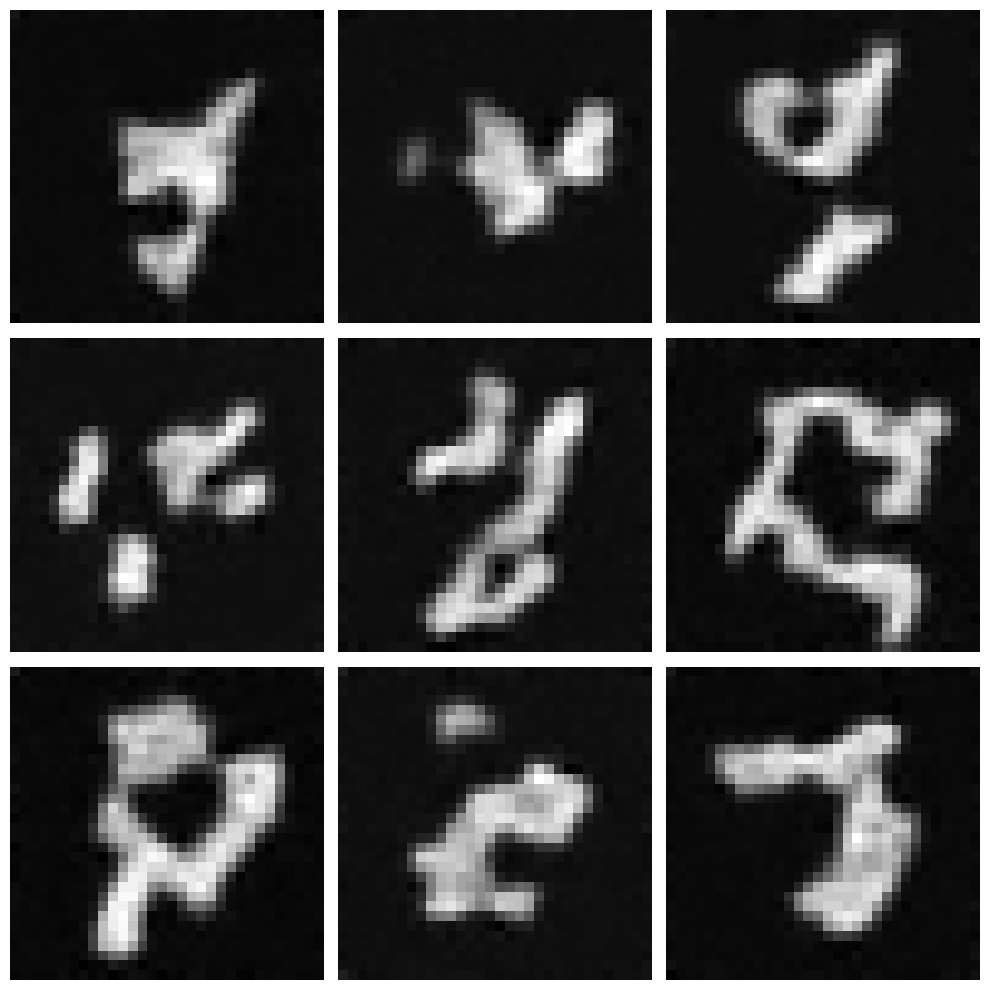

 99%|█████████▊| 987/1000 [00:04<00:00, 200.96it/s]

Showing/saving samples from epoch 4


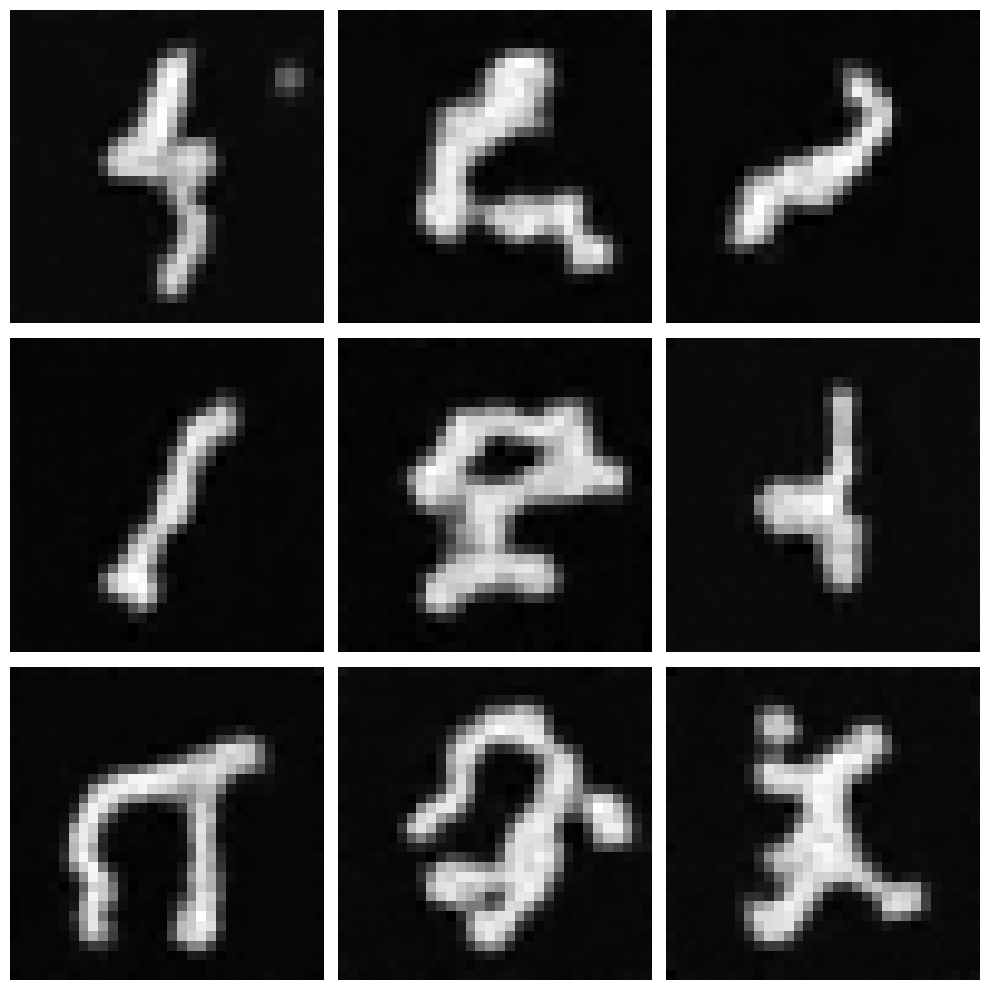

 99%|█████████▊| 986/1000 [00:04<00:00, 204.15it/s]

Showing/saving samples from epoch 6


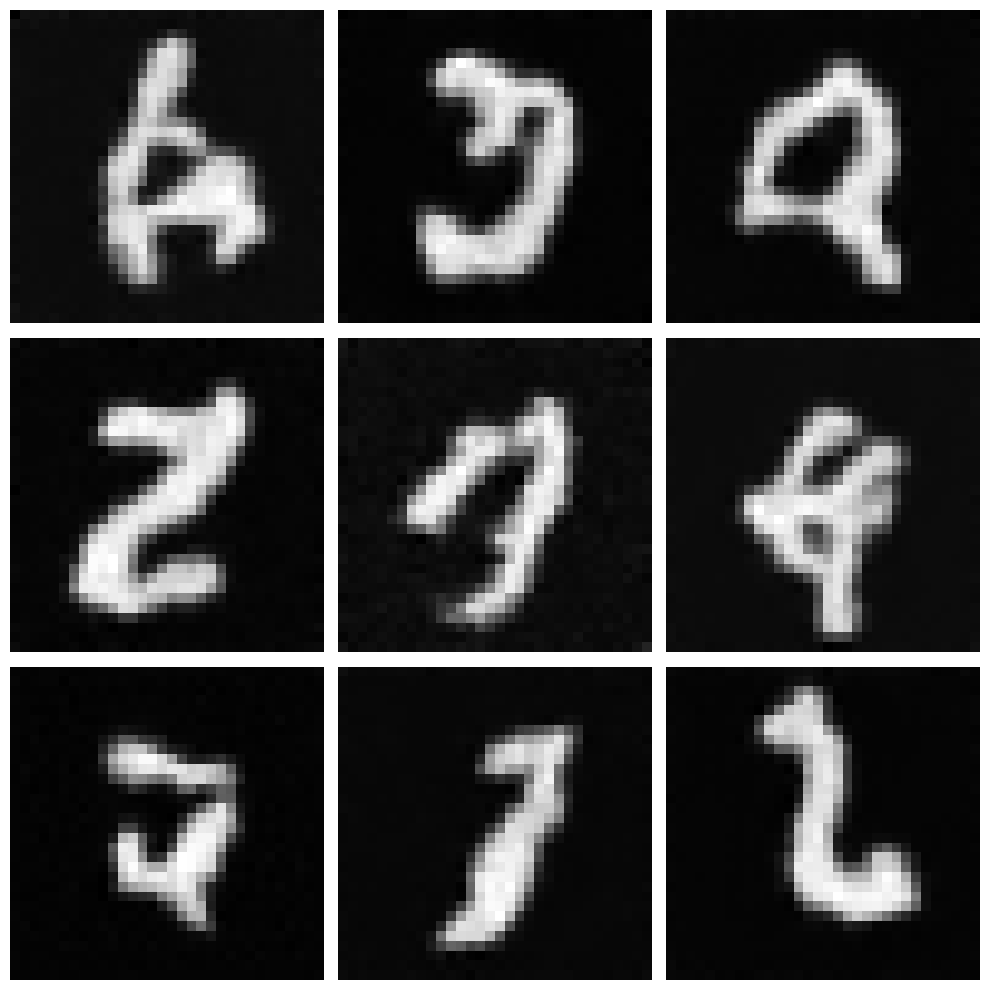

 99%|█████████▊| 987/1000 [00:04<00:00, 206.76it/s]

Showing/saving samples from epoch 8


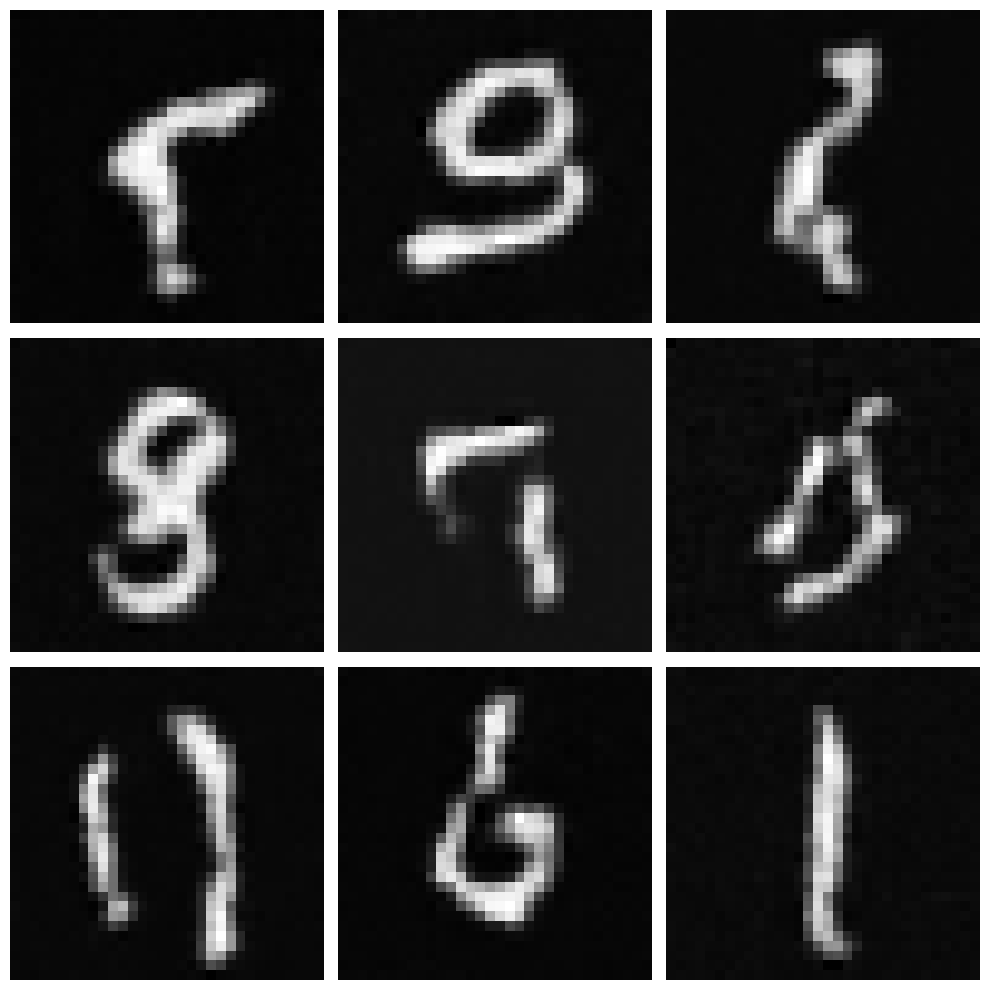

100%|█████████▉| 996/1000 [00:04<00:00, 207.54it/s]

Showing/saving samples from epoch 10


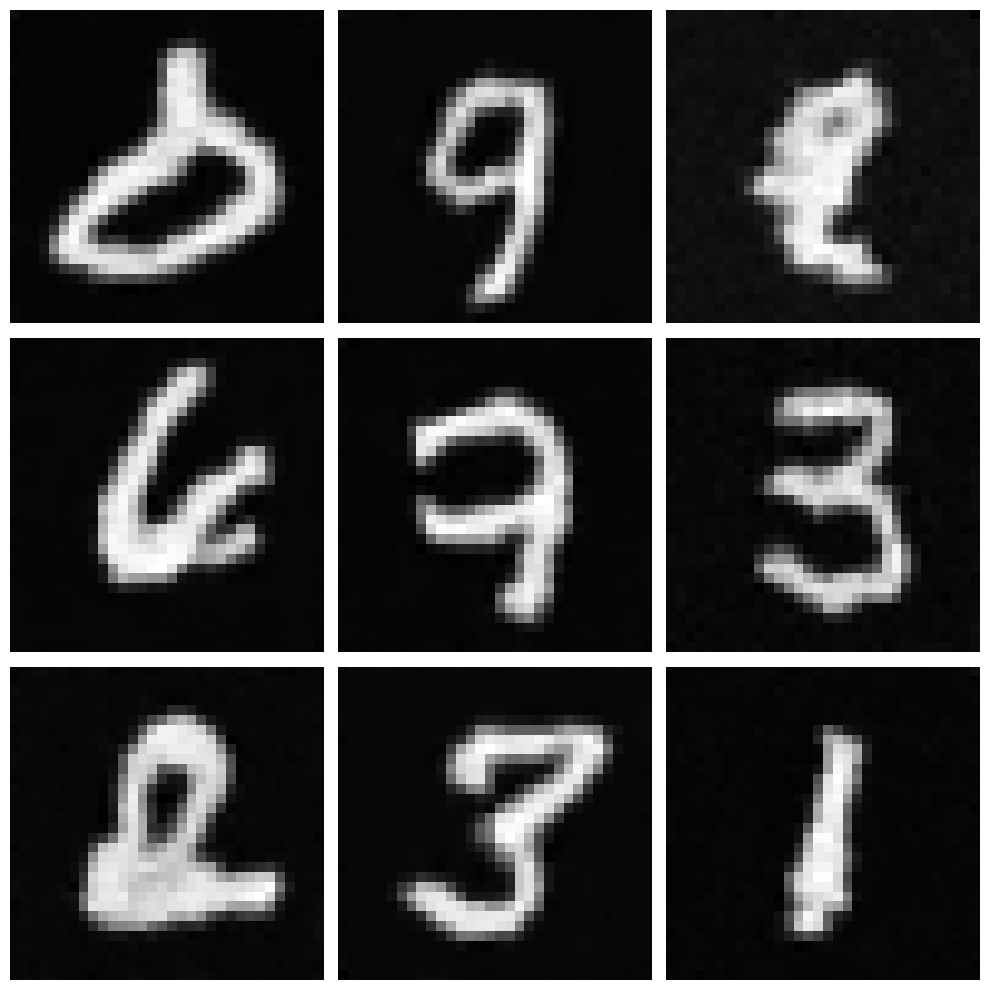

 99%|█████████▊| 987/1000 [00:04<00:00, 203.56it/s]

Showing/saving samples from epoch 12


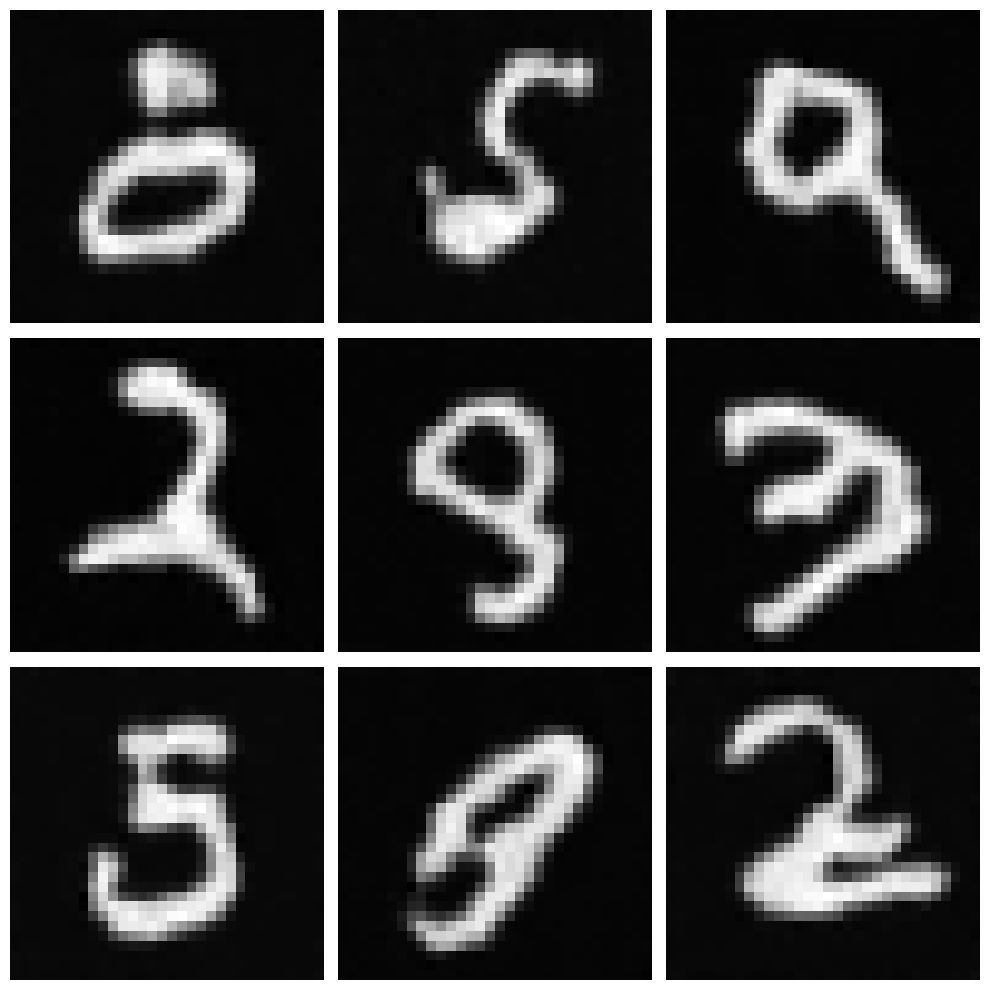

 99%|█████████▊| 987/1000 [00:04<00:00, 206.11it/s]

Showing/saving samples from epoch 14


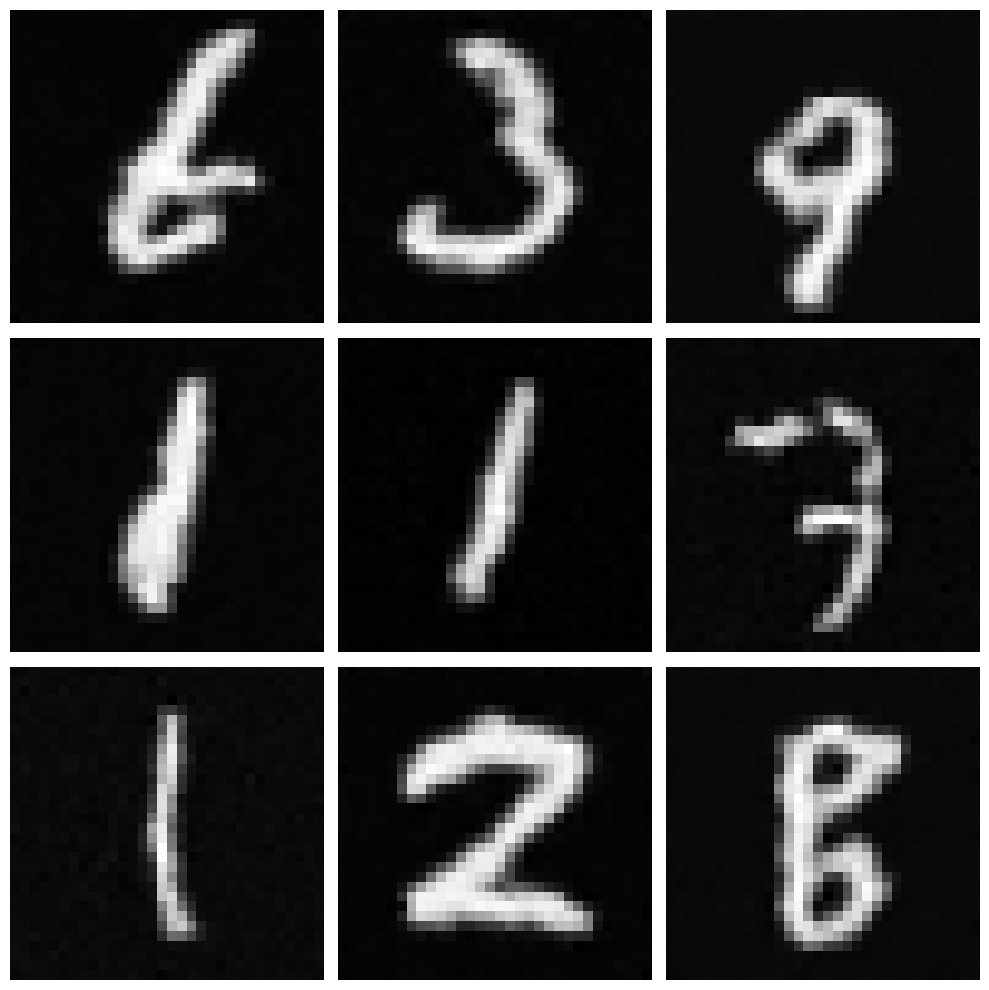

 98%|█████████▊| 985/1000 [00:04<00:00, 206.08it/s]

Showing/saving samples from epoch 16


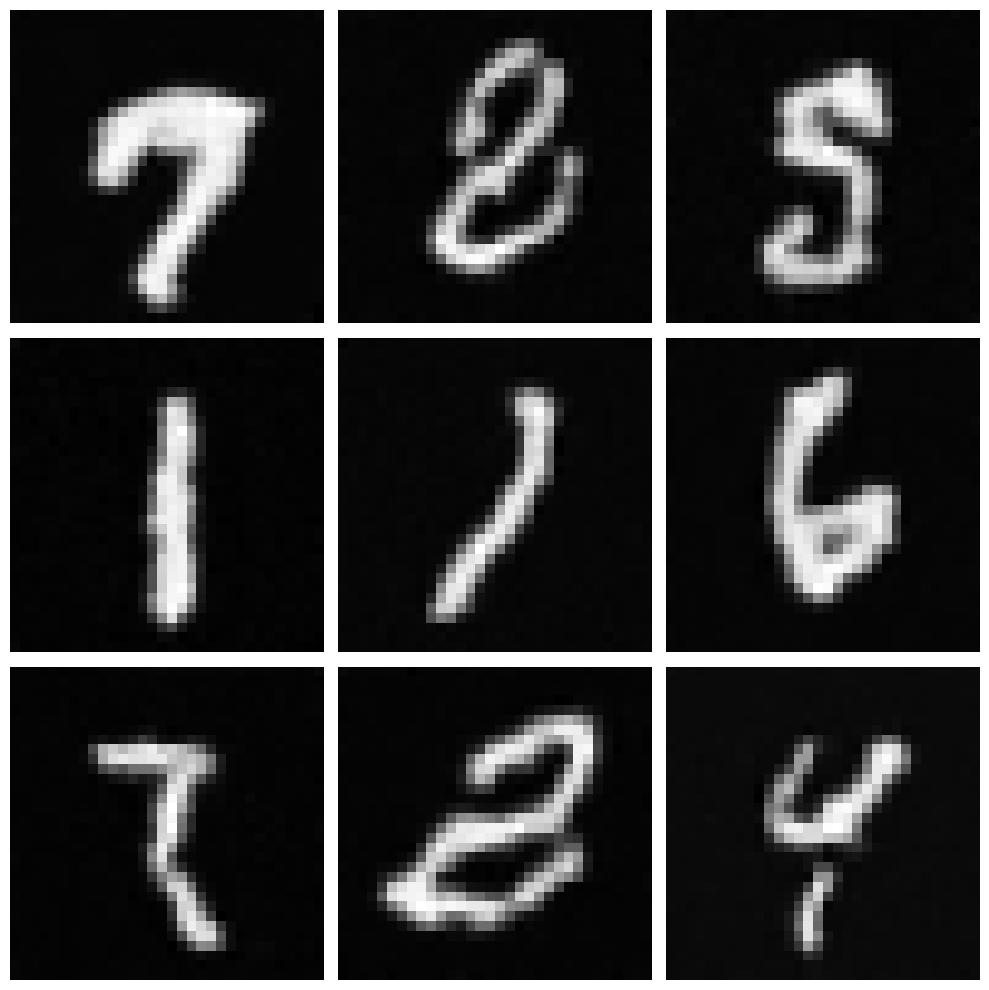

 98%|█████████▊| 984/1000 [00:04<00:00, 211.20it/s]

Showing/saving samples from epoch 18


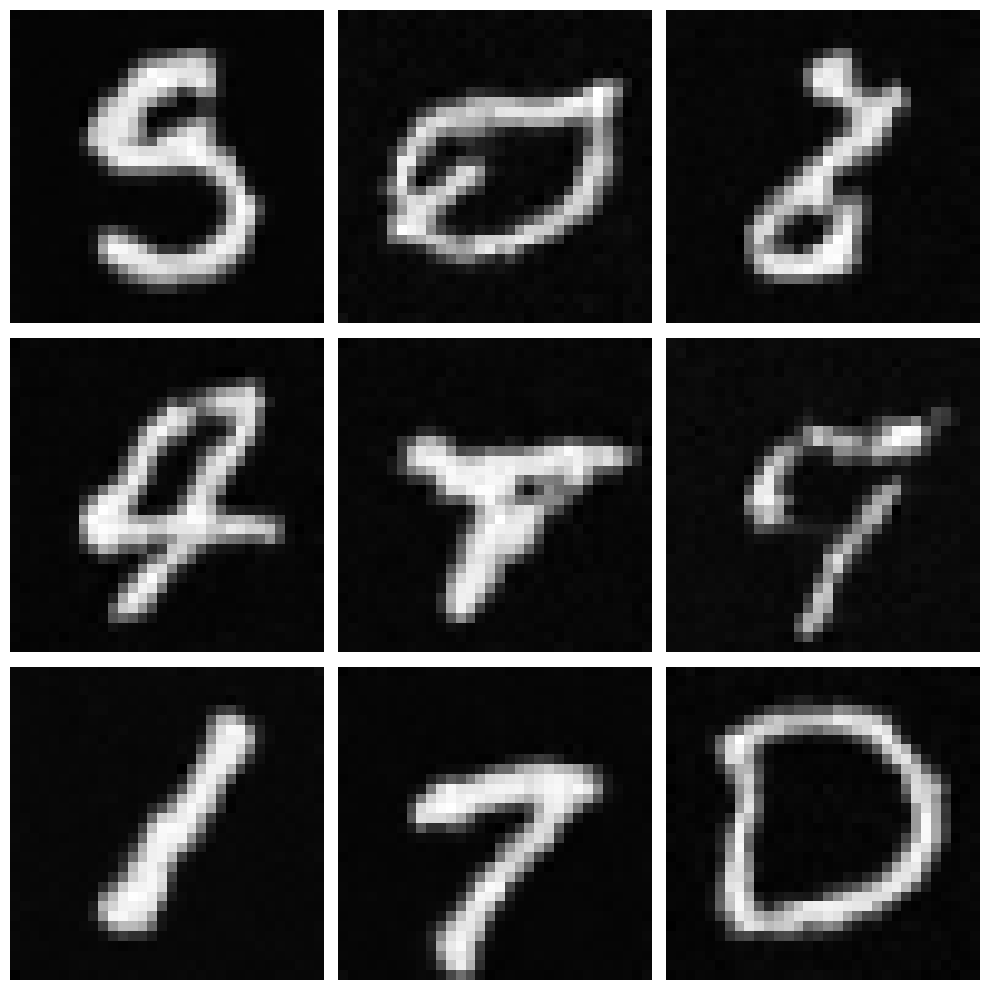

Epoch: 19/20 - lr: 2e-05 - Loss: 14.4: 100%|██████████| 234/234 [00:14<00:00, 15.83it/s] 


In [8]:
trainer.train(dataloader)

# Generate intermediate images from the trained model

In [9]:
steps_to_show = list(range(0, args.n_steps, 100)) + [args.n_steps-1]
steps_to_show = [0, 100, 500, 800, 900, 950, 980, 999]
images = trainer.generate_intermediate_samples(n_samples=4, steps_to_show=steps_to_show)


100%|██████████| 1000/1000 [00:00<00:00, 9835.26it/s]


/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [0,0,0], thread: [0,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [0,0,0], thread: [1,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [0,0,0], thread: [2,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [0,0,0], thread: [3,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.


<Figure size 2500x6000 with 0 Axes>

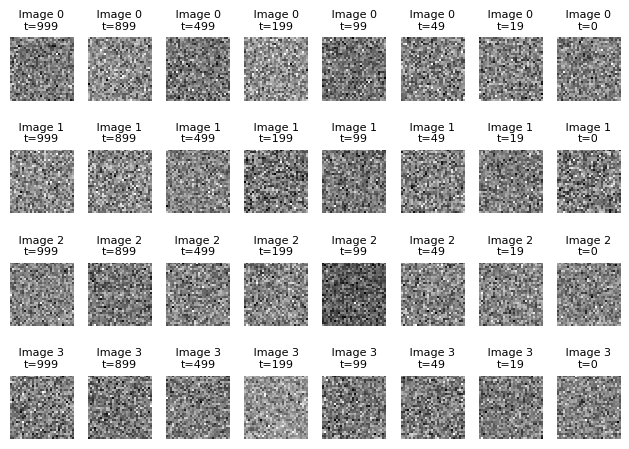

In [11]:
def plot_intermediate_samples(images, steps_to_show, n_samples):
    """
    Plot the intermediate steps of the diffusion process
    Args:
        images: List of image tensors at different steps
        steps_to_show: List of steps that were captured
        n_samples: Number of images to show
    """
    # Create a figure with n_samples rows and len(steps_to_show) columns
    plt.figure(figsize=(25, 15*n_samples))
    fig, axs = plt.subplots(n_samples, len(steps_to_show))
    # Plot each image
    for sample_idx in range(n_samples):
        for step_idx, img in enumerate(images):
            axs[sample_idx, step_idx].imshow(img[sample_idx, 0], cmap='gray')
            step = steps_to_show[step_idx] if step_idx < len(steps_to_show) else args.n_steps
            axs[sample_idx, step_idx].set_title(f' Image {sample_idx} \nt={args.n_steps - step-1}',size=8)
            axs[sample_idx, step_idx].axis('off')

    plt.tight_layout()
    plt.show()
plot_intermediate_samples(images, steps_to_show, n_samples=4)
